In [3]:
#loading the modules
import csv
import pandas as pd
import sys
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import numpy as np

[nltk_data] Downloading package stopwords to C:\Users\ABHINEET
[nltk_data]     SINGH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#loading the modules
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [5]:
#loading the modules
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#reading the negative reviews
df_csv = pd.read_csv('neg_rev.csv')
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13279 entries, 0 to 13278
Data columns (total 3 columns):
text       13269 non-null object
rating     13279 non-null float64
summary    13279 non-null object
dtypes: float64(1), object(2)
memory usage: 311.4+ KB


In [7]:
#extracting the first 10000 negative reviews
n_reviews = df_csv.iloc[:13000,0:2]
n_reviews = n_reviews.assign(rating = 0)


In [8]:
#reading the positive reviews
df_csv = pd.read_csv('pos_rev.csv')
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108664 entries, 0 to 108663
Data columns (total 3 columns):
text       108602 non-null object
rating     108664 non-null float64
summary    108663 non-null object
dtypes: float64(1), object(2)
memory usage: 2.5+ MB


In [9]:
#extracting the first 10000 positive reviews
p_reviews = df_csv.iloc[:13000,0:2]
p_reviews = p_reviews.assign(rating = 1)

In [10]:
#creating a sinlge dataframe of 20000 reviews by concatenating pos and neg reviews
result = pd.concat([n_reviews, p_reviews], ignore_index=True)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 2 columns):
text      25978 non-null object
rating    26000 non-null int64
dtypes: int64(1), object(1)
memory usage: 406.4+ KB


In [11]:
#some preprocessing functions
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    #print(stopwords_list)
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list and word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [12]:
result = result[result['text'].notnull()]
result.text = result.text.apply(remove_stopwords).apply(remove_mentions)
#result

In [13]:
#removing the punctuations
result['text'] = result['text'].str.replace('[^\w\s]','')


In [14]:
#converting everything to lowercase
result['text'] = result['text'].str.lower()

In [15]:
#shuffing the dataframe so that all positive/negative are not together

result = result.sample(frac=1).reset_index(drop=True)


In [16]:
#taking the most frequent 20000 words and vectorizing them
NB_WORDS = 20000
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(result.text)


In [17]:
#vector of the training data
X_train =  result.iloc[:20000,0:1]
#X_train
X_train = tk.texts_to_sequences(X_train.text)
#print((X_train[0]))


In [61]:
#vector of the training labels
Y_train =  result.iloc[:20000,1:2]
#print((Y_train))
Y_train.groupby('rating').size()

rating
0    10073
1     9927
dtype: int64

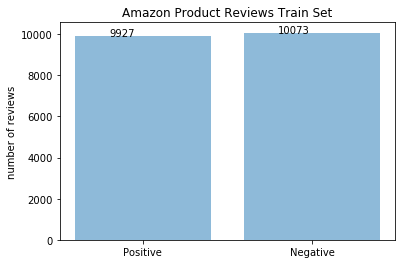

In [75]:
#fig, ax = plt.subplots()
objects = ('Positive', 'Negative')
y_pos = np.arange(len(objects))
performance = [9927,10073]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of reviews')
plt.title('Amazon Product Reviews Train Set')
for i, v in enumerate(performance):
    plt.text(i - 0.2, v + 0.1, str(v))
plt.show()

In [19]:
x = Y_train["rating"].tolist()
Y_train = x


In [20]:
#vector of the testing data
X_test =  result.iloc[20000:,0:1]
#X_test
X_test = tk.texts_to_sequences(X_test.text)
print(len(X_test))

5978


In [21]:
#vector of the training labels
Y_test =  result.iloc[20000:,1:2]
#Y_test

In [22]:
Y_test.groupby('rating').size()

rating
0    2917
1    3061
dtype: int64

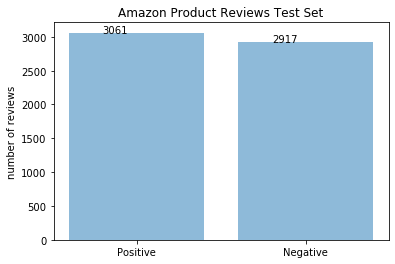

In [78]:
objects = ('Positive', 'Negative')
y_pos = np.arange(len(objects))
performance = [3061,2917]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of reviews')
plt.title('Amazon Product Reviews Test Set')
for i, v in enumerate(performance):
    plt.text(i - 0.2, v + 0.1, str(v))
plt.show()

In [23]:
age_list = Y_test["rating"].tolist()
Y_test = age_list


In [24]:
#print((Y_test))

In [25]:
#padding to a maximum length of 80
X_train = pad_sequences(X_train, maxlen=80)
X_test = pad_sequences(X_test, maxlen=80)


In [26]:
#converting the testing and the training data to numpy arrays
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
print(Y_train)

[0 0 1 ... 1 1 0]


In [27]:
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [28]:
print((X_train.shape))

(20000, 80)


In [29]:
print((Y_train))

[0 0 1 ... 1 1 0]


In [30]:
print(X_test.shape)


(5978, 80)


In [31]:
print(Y_test)


[1 0 0 ... 0 0 0]


In [32]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
#creating the model
model = Sequential()
model.add(Embedding(NB_WORDS, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',f1_m,precision_m, recall_m])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])


In [39]:
#training on the testing data
#model.fit(X_train, Y_train, batch_size=125, epochs=2)
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_test,Y_test),batch_size=125)
#history = model.fit(X_train, Y_train, epochs=1,batch_size=125, shuffle=True)


Train on 20000 samples, validate on 5978 samples
Epoch 1/5
20000/20000 [==============================] - 54s 3ms/step - loss: 0.3718 - acc: 0.8296 - f1_m: 0.7888 - precision_m: 0.8441 - recall_m: 0.7854 - val_loss: 0.2527 - val_acc: 0.9021 - val_f1_m: 0.9059 - val_precision_m: 0.8920 - val_recall_m: 0.9214
Epoch 2/5
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1929 - acc: 0.9295 - f1_m: 0.9283 - precision_m: 0.9294 - recall_m: 0.9289 - val_loss: 0.2424 - val_acc: 0.9035 - val_f1_m: 0.9072 - val_precision_m: 0.8941 - val_recall_m: 0.9219
Epoch 3/5
20000/20000 [==============================] - 53s 3ms/step - loss: 0.1323 - acc: 0.9526 - f1_m: 0.9515 - precision_m: 0.9531 - recall_m: 0.9508 - val_loss: 0.2744 - val_acc: 0.9018 - val_f1_m: 0.9044 - val_precision_m: 0.9037 - val_recall_m: 0.9064
Epoch 4/5
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1022 - acc: 0.9637 - f1_m: 0.9630 - precision_m: 0.9649 - recall_m: 0.9621 - val_loss: 0.29

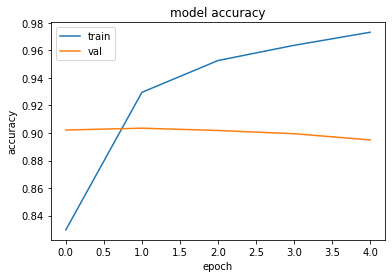

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

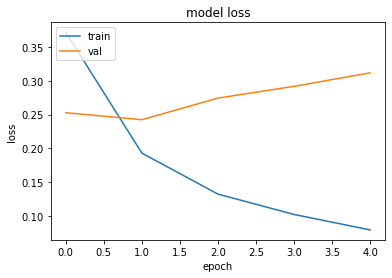

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

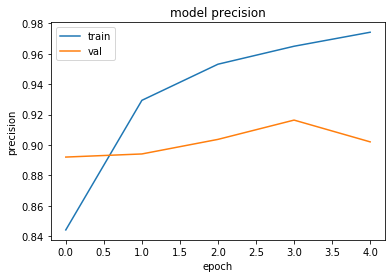

In [42]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

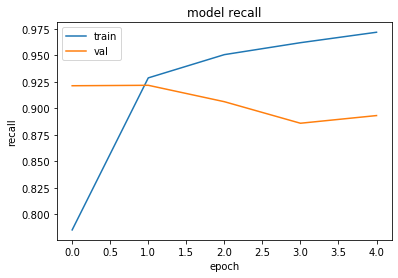

In [43]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

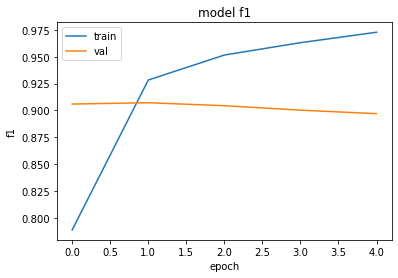

In [44]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [121]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.2434122662264673 0.9014720641158823 0.8989971803956783 0.8988620985228308 0.9042597145450358


In [45]:
prediction = model.predict(X_test)
print(prediction)
prediction = prediction > 0.5

[[0.9995783 ]
 [0.00740437]
 [0.13036183]
 ...
 [0.00568486]
 [0.00808292]
 [0.00107753]]


In [123]:
print(prediction)

[[False]
 [False]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]


In [46]:
prediction = (prediction > .5).astype(int)

In [47]:
#prediction = prediction.tolist()
print(prediction)
#prediction = prediction.tolist()

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [48]:
merged_list = []

for l in prediction:
    merged_list += l


merged_list = np.asarray(merged_list)

list_of_lists = prediction
flattened = [val for sublist in list_of_lists for val in sublist]

In [49]:
#
flattened = np.asarray(flattened)
print(flattened)

[1 0 0 ... 0 0 0]


In [50]:
print(Y_test)

[1 0 0 ... 0 0 0]


In [52]:
a = np.array(Y_test)
b = np.array(flattened)
np.sum(a == b)

5350

In [53]:
from sklearn.metrics import confusion_matrix

In [56]:
cnf_matrix = confusion_matrix(Y_test, flattened)
print(cnf_matrix)

[[2617  300]
 [ 328 2733]]


In [77]:
#plt.matshow(cnf_matrix, cmap='binary')

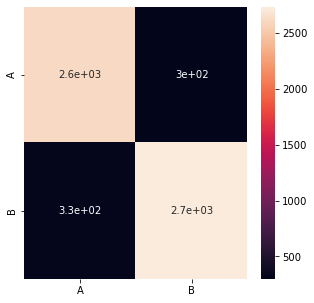

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix
df_cm = pd.DataFrame(array, index = [i for i in "AB"],
                  columns = [i for i in "AB"])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)